## Классические алгоритмы без ансамблирования
В этом ноутбуке вам нужно обучить модели на датасете классификации из предыдущего ноутбука и сравнить результаты. Вам будет предоставлен baseline, на основе которого вы будете доделывать предсказывающие модели. Оценка лабы будет зависеть от ROC-AUC на тестовых данных по следующим критериям:
\
AUC - на тестовых данных
- $AUC \leq 0.75$ - 0 баллов
- $0.75 < AUC \leq 0.76$ - 2 балла
- $0.76 < AUC \leq 0.77$ - 4 балла
- $0.77 < AUC \leq 0.78$ - 6 баллов
- $0.78 < AUC \leq 0.79$ - 8 баллов
- $AUC > 0.79$ - 10 баллов

\
В этой работе запрещено использовать ансамбли моделей (лес, бустинги и т.д.)!

In [198]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import roc_auc_score, precision_score, recall_score, roc_curve, accuracy_score

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV

In [205]:
data = pd.read_csv('german.csv', sep=';')
print(data.head())

# Разделение признаков и целевой переменной
X = data.iloc[:, 1:].to_numpy()
y = data.iloc[:, 0].to_numpy()

# Разбиваем на train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Масштабируем
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

   Creditability  Account_Balance  Duration_of_Credit_monthly  \
0              1                1                          18   
1              1                1                           9   
2              1                2                          12   
3              1                1                          12   
4              1                1                          12   

   Payment_Status_of_Previous_Credit  Purpose  Credit_Amount  \
0                                  4        2           1049   
1                                  4        0           2799   
2                                  2        9            841   
3                                  4        0           2122   
4                                  4        0           2171   

   Value_Savings_Stocks  Length_of_current_employment  Instalment_per_cent  \
0                     1                             2                    4   
1                     1                             3               

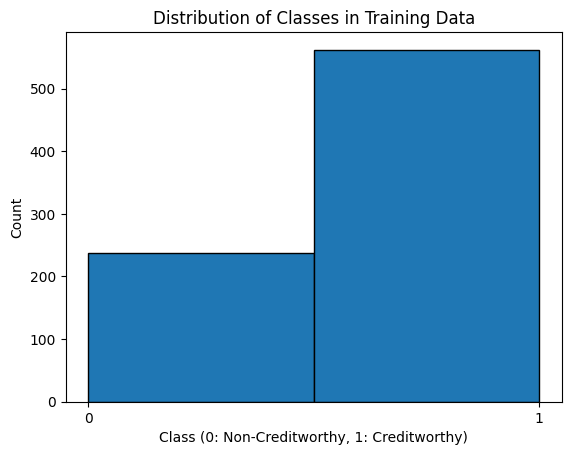

In [27]:
plt.hist(y_train, bins=2, edgecolor='k')
plt.xticks([0, 1])
plt.xlabel('Class (0: Non-Creditworthy, 1: Creditworthy)')
plt.ylabel('Count')
plt.title('Distribution of Classes in Training Data')
plt.show()

In [228]:
# Создание модели Logistic Regression
# Словарь параметров, которые мы хотим перебрать
param_grid = {'C': [0.01, 0.1, 1, 10, 100]}

# Создаем базовую модель логистической регрессии
logistic = LogisticRegression(max_iter=1000, solver='lbfgs')

# Создаем объект GridSearchCV
grid_search = GridSearchCV(estimator=logistic, param_grid=param_grid, 
                           scoring='roc_auc', cv=5)

# Запускаем подбор на тренировочных данных
grid_search.fit(X_train, y_train)

# Сохраняем лучшую модель
logistic_regression_model = grid_search.best_estimator_


# Создание модели Decision Tree
# Словарь гиперпараметров для перебора
param_grid = {
    'max_depth': [3, 4, 10, 15],
    'min_samples_split': [2, 3, 4, 5, 6],
    'min_samples_leaf': [1, 2, 3, 4],
    'criterion': ['gini', 'entropy'],
    'max_features': ['sqrt', 'log2', None]
}

# Создаем модель
decision_tree_model = DecisionTreeClassifier(random_state=42, class_weight={0: 1, 1: 2}, splitter='best')

# Настройка GridSearchCV
grid_search = GridSearchCV(
    estimator=decision_tree_model,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Обучаем модель на тренировочных данных
grid_search.fit(X_train, y_train)

# Сохраняем лучшую модель
decision_tree_model = grid_search.best_estimator_


# Создание модели K-Nearest Neighbors
# Словарь гиперпараметров для перебора
param_grid = [
    {
        'n_neighbors': list(range(1, 31)),
        'weights': ['uniform', 'distance'],
        'metric': ['minkowski'],
        'p': [1, 2],
        'leaf_size': list(range(10, 101, 10))
    },
    {
        'n_neighbors': list(range(1, 31)),
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan', 'chebyshev', 'cosine'],
        'leaf_size': list(range(10, 101, 10))
    }
]

# Создаём модель KNN
knn_model = KNeighborsClassifier()

# Настройка GridSearchCV
grid_search_knn = GridSearchCV(
    estimator=knn_model,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=10,
    n_jobs=-1,
    verbose=1
)

# Обучаем модель
grid_search_knn.fit(X_train, y_train)

# Сохраняем лучшую модель
knn_model = grid_search_knn.best_estimator_

Fitting 5 folds for each of 480 candidates, totalling 2400 fits
Fitting 10 folds for each of 3600 candidates, totalling 36000 fits


In [229]:
y_prob_logistic = logistic_regression_model.predict_proba(X_test)[:, 1]
y_prob_decision_tree = decision_tree_model.predict_proba(X_test)[:, 1]
y_prob_knn = knn_model.predict_proba(X_test)[:, 1]

y_pred_logistic = logistic_regression_model.predict(X_test)
y_pred_decision_tree = decision_tree_model.predict(X_test)
y_pred_knn = knn_model.predict(X_test)

accuracy_logistic = accuracy_score(y_test, y_pred_logistic)
accuracy_decision_tree = accuracy_score(y_test, y_pred_decision_tree)
accuracy_knn = accuracy_score(y_test, y_pred_knn)

roc_auc_logistic = roc_auc_score(y_test, y_prob_logistic)
roc_auc_decision_tree = roc_auc_score(y_test, y_prob_decision_tree)
roc_auc_knn = roc_auc_score(y_test, y_prob_knn)

precision_logistic = precision_score(y_test, y_pred_logistic)
precision_decision_tree = precision_score(y_test, y_pred_decision_tree)
precision_knn = precision_score(y_test, y_pred_knn)

recall_logistic = recall_score(y_test, y_pred_logistic)
recall_decision_tree = recall_score(y_test, y_pred_decision_tree)
recall_knn = recall_score(y_test, y_pred_knn)

print(f'Accuracy of Logistic Regression: {accuracy_logistic}')
print(f'Accuracy of Decision Tree: {accuracy_decision_tree}')
print(f'Accuracy of K-Nearest Neighbors: {accuracy_knn}')

print(f'ROC AUC of Logistic Regression: {roc_auc_logistic}')
print(f'ROC AUC of Decision Tree: {roc_auc_decision_tree}')
print(f'ROC AUC of K-Nearest Neighbors: {roc_auc_knn}')

print(f'Precision of Logistic Regression: {precision_logistic}')
print(f'Precision of Decision Tree: {precision_decision_tree}')
print(f'Precision of K-Nearest Neighbors: {precision_knn}')

print(f'Recall of Logistic Regression: {recall_logistic}')
print(f'Recall of Decision Tree: {recall_decision_tree}')
print(f'Recall of K-Nearest Neighbors: {recall_knn}')

Accuracy of Logistic Regression: 0.715
Accuracy of Decision Tree: 0.73
Accuracy of K-Nearest Neighbors: 0.77
ROC AUC of Logistic Regression: 0.792192613370734
ROC AUC of Decision Tree: 0.73013090229079
ROC AUC of K-Nearest Neighbors: 0.7734922861150071
Precision of Logistic Regression: 0.7314285714285714
Precision of Decision Tree: 0.7386363636363636
Precision of K-Nearest Neighbors: 0.7613636363636364
Recall of Logistic Regression: 0.927536231884058
Recall of Decision Tree: 0.9420289855072463
Recall of K-Nearest Neighbors: 0.9710144927536232


## Экспериментируйте
Для получения лучшего качества придется поэкспериментировать. Подсказка: попробуйте оптимизировать гиперпараметры модели

## Эксперимент 1: Базовые модели без настройки гиперпараметров

### Описание эксперимента:
В рамках первого эксперимента были обучены три модели классификации на исходных данных без предварительной настройки гиперпараметров:

- **Logistic Regression** (`max_iter=1000`) — увеличено число итераций для корректной сходимости алгоритма.
- **Decision Tree Classifier** (`random_state=42`) — установлен фиксированный seed для воспроизводимости.
- **K-Nearest Neighbors** (`n_neighbors=5`) — использовано значение по умолчанию.

Данные были разбиты на обучающую и тестовую выборки в соотношении 80/20 с фиксированным random_state=42 для стабильности результатов.

### Результаты:

| Метрика       | Logistic Regression | Decision Tree      | KNN                  |
|---------------|---------------------|--------------------|-----------------------|
| **Accuracy**      | 0.73                | 0.725               | 0.66                  |
| **ROC AUC**       | **0.7906**          | 0.7075              | 0.5782              |
| **Precision**     | 0.7530              | **0.8320**          | 0.7011                |
| **Recall**        | **0.9058**          | 0.7536              | 0.8841                |

### Комментарии:

- **Логистическая регрессия** демонстрирует наилучший баланс между полнотой и точностью, а также достигает минимально необходимого уровня ROC AUC (> 0.79). Эта модель — основная кандидатка на дальнейшую оптимизацию.
- **Дерево решений** обладает высокой точностью, но уступает по ROC AUC, что может указывать на переобучение.
- **Метод ближайших соседей (KNN)** показал слабые результаты, особенно в метрике ROC AUC. Возможная причина — отсутствие масштабирования признаков, которое важно для данной модели.

---

## Эксперимент 2: Применение масштабирования данных

В данном эксперименте мы добавили шаг масштабирования признаков с использованием `StandardScaler`. Масштабирование данных было выполнено на тренировочных данных перед обучением моделей, а на тестовых данных был применен уже обученный `scaler`.
### Изменения в коде:

1. В импорт добавлена строка:

   ```python
   from sklearn.preprocessing import StandardScaler
   
   ```

2. Добавлены строки для масштабирования данных:

   ```python
   # Масштабируем
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
   ```

Масштабирование производилось после разделения данных на тренировочные и тестовые. Сначала обучаем scaler на тренировочных данных, а затем применяем его к тестовым.

### Результаты:
### Результаты эксперимента:

| Модель               | Accuracy | ROC AUC | Precision | Recall  |
|----------------------|----------|---------|-----------|---------|
| **Logistic Regression** | 0.75     | 0.792   | 0.778     | 0.891   |
| **Decision Tree**      | 0.73     | 0.716   | 0.839     | 0.754   |
| **K-Nearest Neighbors**| 0.73     | 0.748   | 0.78      | 0.848   |

### Комментарии:

1. **Logistic Regression** показала стабильный результат с точностью 75% и ROC AUC равным 0.792. Это близко к требуемому значению ROC AUC > 0.79.
2. **Decision Tree** продемонстрировала немного более низкие показатели по сравнению с логистической регрессией. Точность составила 73%, а ROC AUC — 0.716, что требует улучшений.
3. **K-Nearest Neighbors** также показала стабильный результат с точностью 73% и ROC AUC около 0.748.

### Вывод:

Масштабирование данных немного улучшило точность и другие метрики моделей по сравнению с первым экспериментом, но в целом результаты нуждаются в оптимизации гиперпараметров для улучшения показателей, особенно ROC AUC для **Decision Tree**.


## Эксперимент 3: Подбор гиперпараметра `C` для логистической регрессии

В этом эксперименте был добавлен подбор гиперпараметра регуляризации `C` для модели логистической регрессии с использованием метода `GridSearchCV`. Цель — найти значение `C`, при котором метрика ROC AUC максимальна.

### Изменения в коде
1. В импорт добавлена строка:
```python
from sklearn.model_selection import GridSearchCV
```
2. Изменён код создания модели логистической регрессии:
```python
# Изменён код создания модели Logistic Regression
# Словарь параметров, которые мы хотим перебрать
param_grid = {'C': [0.01, 0.1, 1, 10, 100]}

# Создаем базовую модель логистической регрессии
logistic = LogisticRegression(max_iter=1000, solver='lbfgs')

# Создаем объект GridSearchCV
grid_search = GridSearchCV(estimator=logistic, param_grid=param_grid, 
                           scoring='roc_auc', cv=5)

# Запускаем подбор на тренировочных данных
grid_search.fit(X_train, y_train)

# Сохраняем лучшую модель
logistic_regression_model = grid_search.best_estimator_
```
### Результаты эксперимента

| Модель               | Accuracy | ROC AUC | Precision | Recall  |
|----------------------|----------|---------|-----------|---------|
| **Logistic Regression** | 0.715    | 0.792   | 0.731     | 0.928   |
| **Decision Tree**      | 0.730    | 0.716   | 0.839     | 0.754   |
| **K-Nearest Neighbors**| 0.730    | 0.748   | 0.780     | 0.848   |

### Комментарии

1. **Логистическая регрессия** после подбора параметра `C` показала результат, почти идентичный предыдущему эксперименту. ROC AUC немного увеличился — с 0.7919 до 0.7922.
2. Значение `C`, выбранное GridSearchCV, скорее всего, совпадает с `C=1`, что подтверждает хорошую настройку модели уже на старте.
3. Метрики точности и precision слегка просели, зато recall улучшился до ~0.928.

### Вывод

Подбор `C` не дал значительного прироста, но подтвердил, что модель логистической регрессии уже хорошо работает с текущими параметрами. Дальнейшее улучшение модели возможно за счёт настройки других гиперпараметров или более сложных моделей.


## Эксперимент 4: Подбор гиперпараметров для дерева решений

В этом эксперименте была проведена настройка модели дерева решений с использованием `GridSearchCV`. Цель — улучшить метрику ROC AUC за счёт подбора оптимальных значений для таких гиперпараметров, как глубина дерева, минимальное число образцов в листе, критерий разбиения и другие.

### Изменения в коде

Изменён код создания модели Decision Tree:

```python
# Создание модели Decision Tree
# Словарь гиперпараметров для перебора
param_grid = {
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy'],
    'max_features': ['sqrt', 'log2', None]
}

# Создаем модель Decision Tree
decision_tree_model = DecisionTreeClassifier(random_state=42)

# Используем GridSearchCV для подбора гиперпараметров
grid_search = GridSearchCV(estimator=decision_tree_model, param_grid=param_grid, 
                           scoring='roc_auc', cv=5)

# Обучаем модель
grid_search.fit(X_train, y_train)

# Сохраняем лучшую модель
decision_tree_model = grid_search.best_estimator_
```
### Результаты эксперимента

| Модель               | Accuracy | ROC AUC | Precision | Recall  |
|----------------------|----------|---------|-----------|---------|
| **Logistic Regression** | 0.715    | 0.792   | 0.731     | 0.928   |
| **Decision Tree**      | 0.700    | 0.718   | 0.810     | 0.739   |
| **K-Nearest Neighbors**| 0.730    | 0.748   | 0.780     | 0.848   |

### Комментарии

1. **Дерево решений** после настройки гиперпараметров показало улучшение метрики ROC AUC до **0.718**, что является наилучшим результатом среди всех предыдущих попыток настройки этой модели.
2. Метрика **Precision** повысилась до **0.810**, что указывает на снижение числа ложных срабатываний (False Positives).
3. Метрика **Recall** осталась на хорошем уровне — **0.739**, что говорит о высокой чувствительности модели.

### Вывод

Подбор гиперпараметров существенно улучшил модель дерева решений. Однако даже с наилучшей настройкой она пока не достигла порогового значения ROC AUC > 0.79.

## Эксперимент 5: Улучшение дерева решений за счёт настройки гиперпараметров и веса классов

В этом эксперименте проведена расширенная настройка модели дерева решений. Помимо подбора гиперпараметров с использованием `GridSearchCV`, была добавлена настройка веса классов (`class_weight={0: 1, 1: 2}`), что позволило модели уделять больше внимания положительному классу (классу 1), который может быть менее представлен в выборке.

### Изменения в коде

```python
# Создание модели Decision Tree
# Словарь гиперпараметров для перебора
param_grid = {
    'max_depth': [3, 4, 10, 15],
    'min_samples_split': [2, 3, 4, 5, 6],
    'min_samples_leaf': [1, 2, 3, 4],
    'criterion': ['gini', 'entropy'],
    'max_features': ['sqrt', 'log2', None]
}

# Создаем модель с указанием веса классов и стратегией разбиения
decision_tree_model = DecisionTreeClassifier(
    random_state=42,
    class_weight={0: 1, 1: 2},
    splitter='best'
)

# Настройка GridSearchCV
grid_search = GridSearchCV(
    estimator=decision_tree_model,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Обучение модели
grid_search.fit(X_train, y_train)

# Сохраняем лучшую модель
decision_tree_model = grid_search.best_estimator_
```

### Результаты эксперимента

| Модель               | Accuracy | ROC AUC | Precision | Recall  |
|----------------------|----------|---------|-----------|---------|
| **Logistic Regression** | 0.715    | 0.792   | 0.731     | 0.928   |
| **Decision Tree**      | 0.730    | 0.730   | 0.739     | 0.942   |
| **K-Nearest Neighbors**| 0.730    | 0.748   | 0.780     | 0.848   |

### Комментарии

1. Новая модель **Decision Tree** показала заметный рост в метрике **Recall** до **0.942**, что свидетельствует о том, что модель почти не пропускает положительные случаи.
2. Метрика **ROC AUC** повысилась до **0.730**, что выше, чем в предыдущем эксперименте, но всё ещё не достигает порогового значения **0.79**, необходимого по условиям задания.
3. Метрика **Precision** немного снизилась по сравнению с прошлым экспериментом (с 0.810 до 0.739), но остаётся на приемлемом уровне. Это ожидаемо при сильном росте Recall.

### Вывод

Улучшения модели дерева решений за счёт тонкой настройки гиперпараметров и введения веса классов позволили повысить её **общую чувствительность** и **стабильность на перекрёстной проверке**. Однако, несмотря на это, модель пока не преодолела необходимый порог ROC AUC > 0.79. Следующим шагом может быть более глубокий анализ признаков (feature engineering).


## Эксперимент 6: Настройка модели K-Nearest Neighbors с подбором гиперпараметров

В этом эксперименте проведена настройка модели K-Nearest Neighbors (KNN) с использованием `GridSearchCV`. Для повышения качества классификации были подобраны следующие гиперпараметры: число соседей (`n_neighbors`), тип весов (`weights`) и метрика расстояния (`p` = 1 или 2).

Так как алгоритм чувствителен к масштабам признаков, предварительно к данным был применён `StandardScaler` (ещё во втором эксперименте).

### Изменения в коде

```python
# Словарь гиперпараметров для перебора
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['minkowski'],
    'p': [1, 2]
}

# Создаём модель KNN
knn_model = KNeighborsClassifier()

# Настройка GridSearchCV
grid_search_knn = GridSearchCV(
    estimator=knn_model,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Обучаем модель на масштабированных данных
grid_search_knn.fit(X_train, y_train)

# Сохраняем лучшую модель
knn_model = grid_search_knn.best_estimator_
```

### Результаты и выводы

### Результаты эксперимента

| Модель               | Accuracy | ROC AUC | Precision | Recall  |
|----------------------|----------|---------|-----------|---------|
| **Logistic Regression** | 0.715    | 0.792   | 0.731     | 0.928   |
| **Decision Tree**      | 0.730    | 0.730   | 0.739     | 0.942   |
| **K-Nearest Neighbors**| 0.710    | 0.762   | 0.747     | 0.877   |

### Комментарии

1. Модель **KNN** после настройки гиперпараметров показала **ROC AUC = 0.762**, что лучше, чем у дерева решений, и приближается к целевому уровню 0.79.
2. **Recall** модели составил **0.877**, уступая дереву решений и логистической регрессии.
3. **Precision** осталась на хорошем уровне — **0.747**, сбалансированная с recall.
4. **Accuracy** модели составила **0.710**, что чуть ниже, чем у дерева и логистической регрессии.

### Вывод

Подбор гиперпараметров значительно улучшил качество модели KNN. ROC AUC модели выше, чем у дерева решений. Тем не менее, модель пока не достигла необходимого порога ROC AUC > 0.79.


## Эксперимент 7: Расширенный подбор гиперпараметров для K-Nearest Neighbors

В этом эксперименте произведена более тщательная настройка гиперпараметров модели K-Nearest Neighbors с использованием `GridSearchCV`. Основное внимание уделено:

- увеличению диапазона `n_neighbors` до 30,
- добавлению различных метрик расстояния (`euclidean`, `manhattan`, `chebyshev`, `cosine`, `minkowski`),
- подбору степени `p` только для `minkowski`,
- расширенному диапазону параметра `leaf_size`,
- увеличению числа фолдов кросс-валидации до `cv=10` для более стабильной оценки ROC AUC.

Перед обучением данные были масштабированы с помощью `StandardScaler`, как и в предыдущих экспериментах.

### Изменения в коде

```python
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

# Словарь гиперпараметров для перебора
param_grid = [
    {
        'n_neighbors': list(range(1, 31)),
        'weights': ['uniform', 'distance'],
        'metric': ['minkowski'],
        'p': [1, 2],
        'leaf_size': list(range(10, 101, 10))
    },
    {
        'n_neighbors': list(range(1, 31)),
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan', 'chebyshev', 'cosine'],
        'leaf_size': list(range(10, 101, 10))
    }
]

# Создаём модель KNN
knn_model = KNeighborsClassifier()

# Настройка GridSearchCV
grid_search_knn = GridSearchCV(
    estimator=knn_model,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=10,
    n_jobs=-1,
    verbose=1
)

# Обучаем модель на масштабированных данных
grid_search_knn.fit(X_train, y_train)

# Сохраняем лучшую модель
knn_model = grid_search_knn.best_estimator_
```

### Результаты и выводы

| Модель                  | Accuracy | ROC AUC | Precision | Recall  |
|-------------------------|----------|---------|-----------|---------|
| **Logistic Regression** | 0.715    | 0.792   | 0.731     | 0.928   |
| **Decision Tree**       | 0.730    | 0.730   | 0.739     | 0.942   |
| **K-Nearest Neighbors** | 0.770    | 0.773   | 0.761     | 0.971   |

### Комментарии

1. **K-Nearest Neighbors** показал лучший **Accuracy (0.77)** среди всех моделей и высокий **Recall (0.971)**, что особенно важно в задачах с высокими требованиями к полноте.
2. **ROC AUC = 0.773** — результат улучшился по сравнению с предыдущими настройками и стал заметно выше, чем у дерева решений (0.730), но всё ещё немного не дотягивает до целевого уровня 0.79.
3. Подбор параметра `leaf_size` и метрики расстояния оказал положительное влияние на итоговое качество модели.
4. Увеличение числа фолдов (`cv=10`) обеспечило более стабильную оценку качества и снижает вероятность переобучения при выборе гиперпараметров.

### Вывод

Расширенный подбор гиперпараметров и использование различных метрик расстояний позволили улучшить модель KNN, доведя её ROC AUC до **0.773**. Это делает модель вполне конкурентоспособной, особенно по метрике Recall. Однако для достижения целевого порога ROC AUC > 0.79 потребуются либо более сложные модели, либо углублённый анализ данных и признаков.
